In [59]:
from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import sys
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from probe_utils import *

from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple
import os
# os.chdir("/data/tianyu_guo/birth")
from data import DataArgs, Dataset, iterate_batches, make_dataset
from ihead_full_model import ModelArgs, Transformer, forward_hook, test_value, test_sink

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# First look at the risk at normal sequences

In [131]:
run_path_server = "/data/tianyu_guo/birth/gens/pre_final/dormant_copy"
# run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, n_layers=1, n_heads=1, bos_num=1, train_steps=9980, delim=0, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu_guo/birth/data")
hook = forward_hook(target_layers=[], target_name="")
predicts, outputs_list = model.modified_forward_with_hook(x, hook)
model.cuda()
markov_tok = [i for i in ds.tok_range if i not in ds.idxs and i not in ds.bos and i != ds.delimiter]

x_dormant = torch.LongTensor([ds.bos + markov_tok + [i] for i in ds.tok_range]).cuda()
predicts_dormant, outputs_list_dormant = model.modified_forward_with_hook(x_dormant, hook)
outputs_list_dormant = move_device(outputs_list_dormant)
predicts_dormant = predicts_dormant.cpu().detach()

x_dormant2 = torch.LongTensor([ds.bos + list(ds.norm_tok_range) + [i] for i in ds.tok_range]).cuda()
predicts_dormant2, outputs_list_dormant2 = model.modified_forward_with_hook(x_dormant2, hook)
outputs_list_dormant2 = move_device(outputs_list_dormant2)
predicts_dormant2 = predicts_dormant2.cpu().detach()

In [132]:
cutoff = 0.8
trigger_toks = [i for i in ds.tok_range if outputs_list_dormant2[0]['attn_weights'][i, 0, -1, 0]<cutoff]
attns_to_0 = outputs_list_dormant2[0]['attn_weights'][:, 0, -1, 0].detach().cpu().numpy()
trigger_toks

[1, 2, 3, 6, 8, 9, 10, 11, 12, 42, 43, 58, 63, 64, 65]

In [158]:
stable_score = dict()
for i in range(65):
    tmp = outputs_list_dormant2[0]['attn_logits'][0, 0, i:, i]
    stable_score[x_dormant2[0, i]] = tmp.std() / tmp.mean()
stable_score

{tensor(65, device='cuda:0'): tensor(0.5950, grad_fn=<DivBackward0>),
 tensor(0, device='cuda:0'): tensor(1.3020, grad_fn=<DivBackward0>),
 tensor(1, device='cuda:0'): tensor(1.8163, grad_fn=<DivBackward0>),
 tensor(2, device='cuda:0'): tensor(0.9037, grad_fn=<DivBackward0>),
 tensor(3, device='cuda:0'): tensor(0.8268, grad_fn=<DivBackward0>),
 tensor(4, device='cuda:0'): tensor(0.9209, grad_fn=<DivBackward0>),
 tensor(5, device='cuda:0'): tensor(0.7573, grad_fn=<DivBackward0>),
 tensor(6, device='cuda:0'): tensor(0.8142, grad_fn=<DivBackward0>),
 tensor(7, device='cuda:0'): tensor(2.7000, grad_fn=<DivBackward0>),
 tensor(8, device='cuda:0'): tensor(1.7071, grad_fn=<DivBackward0>),
 tensor(9, device='cuda:0'): tensor(-0.9551, grad_fn=<DivBackward0>),
 tensor(10, device='cuda:0'): tensor(0.7775, grad_fn=<DivBackward0>),
 tensor(11, device='cuda:0'): tensor(1.3285, grad_fn=<DivBackward0>),
 tensor(12, device='cuda:0'): tensor(0.7531, grad_fn=<DivBackward0>),
 tensor(13, device='cuda:0'):

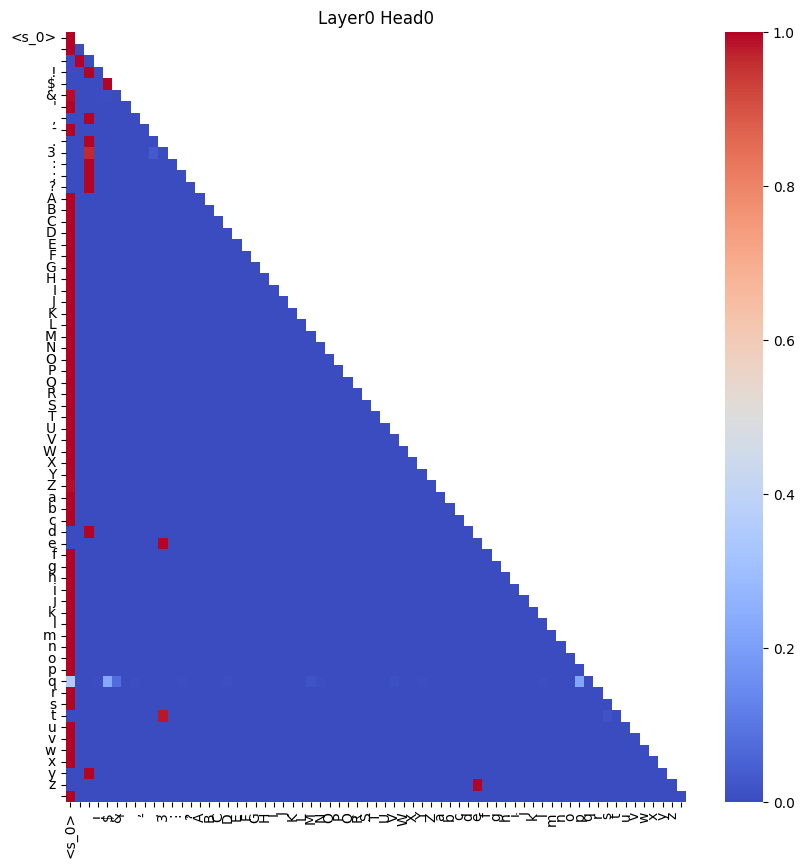

In [138]:
seq_len = 67
seq_idx = 0
layer_idx = 0
head_idx = 0
sub_seq = x_dormant2.detach().cpu()[seq_idx, :seq_len].numpy().copy()
text = ds.decode(sub_seq)
fig, ax = plt.subplots(figsize=(10, 10))
plot_attns(cfg, ax, seq_idx, head_idx, layer_idx, seq_len, outputs_list_dormant2, text)
plt.show()

In [64]:
oracle_risk = -torch.log(torch.from_numpy(ds.cond))
oracle_risk[oracle_risk == float("Inf")] = 0
oracle_risk = oracle_risk @ ds.cond
emp_risk = -torch.log(torch.nn.functional.softmax(predicts_dormant[:, -1, :], dim=-1)) @ ds.cond
emp_risk2 = -torch.log(torch.nn.functional.softmax(predicts_dormant2[:, -1, :], dim=-1)) @ ds.cond
emp_risks = [(i, emp_risk[i, i], emp_risk2[i, i], oracle_risk[i, i]) for i in ds.tok_range]

In [104]:
def get_oracle_predicts(x, ds):
    B, N, V = x.shape[0], x.shape[1], ds.num_tokens
    predicts_oracle = np.zeros((B, N, V))
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if x[i, j] in ds.idxs:
                predicts_oracle[i, j, x[i, j-1]] = 1
            else:
                predicts_oracle[i, j, :] = ds.cond[x[i, j]]
    return torch.from_numpy(predicts_oracle).float()

def get_risk(probs, predicts, predict_in_logits):
    if predict_in_logits:
        predicts = torch.nn.functional.softmax(predicts, dim=-1)
    loss = - torch.log(predicts)
    loss[torch.where(probs == 0)] = 0
    risk = torch.einsum("ikj,ikj->ik", probs, loss)
    return risk

In [105]:
predicts_oracle = get_oracle_predicts(x, ds)
risk = get_risk(predicts_oracle, predicts, predict_in_logits=True)
risk[:, 1:].mean()

tensor(1.6430, grad_fn=<MeanBackward0>)

In [110]:
predicts_oracle_dormant = get_oracle_predicts(x_dormant, ds)
risk_OOD = get_risk(predicts_oracle_dormant, predicts_dormant, predict_in_logits=True)
risk_optimal = get_risk(predicts_oracle_dormant, predicts_oracle_dormant, predict_in_logits=False)
risk_OOD[:, 1:-1].mean(), risk_optimal[:, 1:-1].mean()

(tensor(2.0191), tensor(1.8734))

In [115]:
risk_OOD[0, 1:-1], x_dormant[0]

(tensor([3.0440e+00, 8.1213e-01, 7.8390e-01, 8.6641e+00, 2.0594e+00, 6.6017e-01,
         2.8465e+00, 4.6918e-01, 1.8148e-03, 4.4817e-01, 7.3825e-01, 6.2173e-01,
         2.6709e+00, 2.4274e+00, 2.4785e+00, 2.4484e+00, 2.5881e+00, 2.1601e+00,
         2.5091e+00, 2.1952e+00, 2.4453e+00, 1.5516e+00, 1.6741e+00, 2.4110e+00,
         2.3829e+00, 2.6858e+00, 2.5609e+00, 2.5207e+00, 2.4510e-01, 2.8314e+00,
         2.6273e+00, 2.0958e+00, 2.1773e+00, 1.7727e+00, 1.5826e+00, 1.0849e+00,
         1.6690e+00, 7.8852e-01, 2.6435e+00, 2.0652e+00, 2.1564e+00, 2.1536e+00,
         2.1561e+00, 2.5301e+00, 1.9427e+00, 2.4600e+00, 1.2129e+00, 2.0425e+00,
         2.5032e+00, 2.2895e+00, 2.5764e+00, 2.6712e+00, 2.4630e+00, 5.3366e-04,
         2.6789e+00, 2.4589e+00, 2.5508e+00, 8.0869e-01, 2.2630e+00, 2.2453e+00,
         1.6608e+00, 9.1903e-01]),
 tensor([65,  0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3

<BarContainer object of 62 artists>

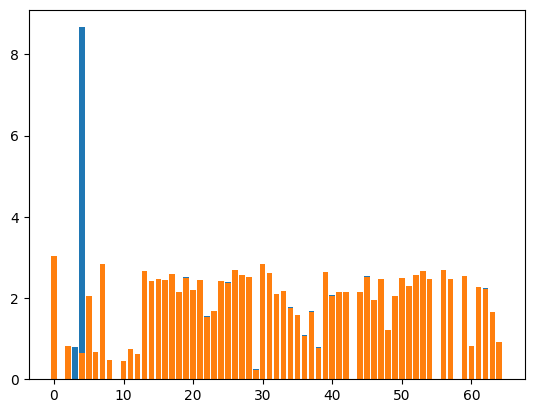

In [113]:
plt.bar(markov_tok, risk_OOD[0, 1:-1])
plt.bar(markov_tok, risk_optimal[0, 1:-1])

In [145]:
predicts_oracle_dormant2 = get_oracle_predicts(x_dormant2, ds)
risk_OOD2 = get_risk(predicts_oracle_dormant2, predicts_dormant2, predict_in_logits=True)
risk_optimal2 = get_risk(predicts_oracle_dormant2, predicts_oracle_dormant2, predict_in_logits=False)
risk_OOD2[:, -1].mean(), risk_optimal2[:, -1].mean()

(tensor(2.2885), tensor(1.8325))

<BarContainer object of 65 artists>

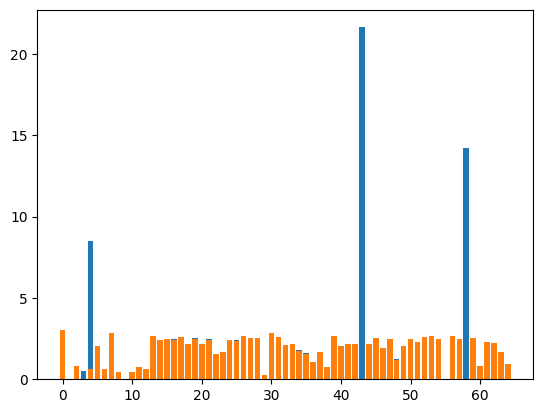

In [140]:
plt.bar(ds.norm_tok_range, risk_OOD2[0, 1:-1])
plt.bar(ds.norm_tok_range, risk_optimal2[0, 1:-1])

In [142]:
[(x_dormant2[0, i], risk_OOD2[0, i], risk_optimal2[0, i]) for i in range(67)]

[(tensor(65, device='cuda:0'), tensor(4.9929), tensor(3.3128)),
 (tensor(0, device='cuda:0'), tensor(3.0440), tensor(3.0430)),
 (tensor(1, device='cuda:0'), tensor(0.0155), tensor(0.)),
 (tensor(2, device='cuda:0'), tensor(0.8114), tensor(0.8108)),
 (tensor(3, device='cuda:0'), tensor(0.5044), tensor(0.)),
 (tensor(4, device='cuda:0'), tensor(8.4814), tensor(0.6365)),
 (tensor(5, device='cuda:0'), tensor(2.0585), tensor(2.0547)),
 (tensor(6, device='cuda:0'), tensor(0.6601), tensor(0.6598)),
 (tensor(7, device='cuda:0'), tensor(2.8486), tensor(2.8361)),
 (tensor(8, device='cuda:0'), tensor(0.4672), tensor(0.4670)),
 (tensor(9, device='cuda:0'), tensor(0.0003), tensor(0.)),
 (tensor(10, device='cuda:0'), tensor(0.4459), tensor(0.4449)),
 (tensor(11, device='cuda:0'), tensor(0.7378), tensor(0.7372)),
 (tensor(12, device='cuda:0'), tensor(0.6208), tensor(0.6195)),
 (tensor(13, device='cuda:0'), tensor(2.6710), tensor(2.6686)),
 (tensor(14, device='cuda:0'), tensor(2.4262), tensor(2.4235))

# Verify that if we manually set attention score from markov tokens to the initial token, risk won't drop